In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from global_land_mask import globe
from scipy import stats
from skmisc.loess import loess

In [2]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K

In [3]:
import glob
merlist = np.sort(glob.glob('../data_merra/lat_30_70/new/MERRA2_*.nc'))
maclist = np.sort(glob.glob('../MACLWP_dailymean/take/wind1deg*.nc4'))

In [4]:
p_mer_T = []
p_mac_w = []

for i in range(len(merlist)): #len(merlist)
    d_path = merlist[i]
    data   = nc.Dataset(d_path)
    # print(d_path)
    
    if i==0:
        merlat = data.variables['lat'][:]
        merlon = data.variables['lon'][:]
        merlev = data.variables['lev'][:]
        #shape latitude
        mer_lat = np.flip(merlat)
        mer_lat = np.array(mer_lat)
        #shape longitude
        mer_lon = np.array(merlon)
        
        
    merT   = data.variables['T'][:] #(time, lev, lat, lon)
    mer_T = np.array(merT[:,:,::-1,:])
    p_mer_T.extend(mer_T)
    
p_mer_T = np.array(p_mer_T)
temp = np.ma.masked_where(p_mer_T == np.max(p_mer_T), p_mer_T)
# temp = np.ma.compressed(temp)

for i in range(len(maclist)): #len(maclist)
    ddpath = maclist[i]
    ddata  = nc.Dataset(ddpath)
    macw   = ddata.variables['sfcwind'][:] #(time,lat,lon)
    # print(ddpath)
    
    if i==0:
        maclat = ddata.variables['lat'][:]
        maclon = ddata.variables['lon'][:]
        #shape latitude
        mac_lat = np.array(maclat)
        slat_ind1 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (31)).argmin()])[0]
        slat_ind2 = np.where(mac_lat == mac_lat.flat[np.abs(mac_lat - (71)).argmin()])[0]
        p_mac_lat  = np.array(mac_lat[slat_ind1[0]:slat_ind2[0]])
        #shape longitude
        maclon[maclon > 180] = maclon[maclon > 180]-360
        mac_lon = np.array(maclon)
        p_mac_lon = []
        p_mac_lon.extend(mac_lon[180::])
        p_mac_lon.extend(mac_lon[0:180])
        p_mac_lon = np.array(p_mac_lon)
    n_w = macw[:,slat_ind1[0]:slat_ind2[0],180::]
    new_w = np.append(n_w,macw[:,slat_ind1[0]:slat_ind2[0],0:180],2)
    p_mac_w.extend(new_w)

p_mac_w = np.array(p_mac_w)
wind = np.ma.masked_where(p_mac_w == np.min(p_mac_w), p_mac_w)
# wind = np.ma.compressed(wind)
wind = np.ma.masked_where(wind < 5, wind)
# wind = np.ma.compressed(wind)
    

In [21]:
merlev

masked_array(data=[1000.,  850.,  800.],
             mask=False,
       fill_value=1e+20)

In [32]:
theta_850 = np.array(np.multiply(temp[:,1,:,:], (100/85)**(Rd/Cp)))
p_theta_850 = np.ma.masked_where(theta_850 == np.max(theta_850), theta_850)

# theta_800 = np.array(np.multiply(temp[:,1,:,:], (100/85)**(Rd/Cp)))
# p_theta_800 = np.ma.masked_where(theta_800 == np.max(theta_800), theta_800)

In [33]:
CAOI = np.array(np.subtract(temp[:,0,:,:],p_theta_850))
p_CAOI = np.ma.masked_where(CAOI == np.max(CAOI), CAOI)
p_CAOI = np.ma.masked_where(p_CAOI < -20, p_CAOI)


In [7]:
maskm = np.ones((len(mer_lat),len(mer_lon)))

for a in range(len(mer_lat)):
    for b in range(len(mer_lon)):
        if globe.is_land(mer_lat[a], mer_lon[b])==True:
            maskm[a,b] = 0

In [34]:
plot_CAOI = np.array(np.multiply(maskm,p_CAOI))
plot_CAOI = np.ma.masked_where(plot_CAOI == np.max(plot_CAOI), plot_CAOI)
plot_CAOI = np.ma.masked_where(plot_CAOI < -20, plot_CAOI)

In [35]:
# plot_mer_theta = np.array(plot_CAOI.reshape(-1))
# plot_mac_wind = np.array(wind.reshape(-1))
plot_mer_theta = plot_CAOI.ravel()
plot_mac_wind = wind.ravel()
# plot_mer_theta = mer_theta[mer_theta != 0]
# plot_mac_wind  = mac_wind[mer_theta != 0]

In [10]:
# print(np.shape(plot_mer_theta))
# print(np.shape(plot_mac_wind))
print('considered theta at 850hPa')
print(np.max(plot_mer_theta))
print(np.max(plot_mac_wind))
print(np.min(plot_mer_theta))
print(np.min(plot_mac_wind))
# print(np.min(xx))
# print(np.min(yy))
# print(np.max(xx))
# print(np.max(yy))
# print(np.shape(plot_CAOI))

considered theta at 850hPa
5.403533935546875
38.4
-19.999969482421875
5.0


In [26]:
# print(np.shape(plot_mer_theta))
# print(np.shape(plot_mac_wind))

print('considered theta at 800hPa')
print(np.max(plot_mer_theta))
print(np.max(plot_mac_wind))
print(np.min(plot_mer_theta))
print(np.min(plot_mac_wind))

considered theta at 800hPa
4.41619873046875
38.4
-20.0
5.0


# plots

Text(0, 0.5, 'Surface wind speed (m/s)')

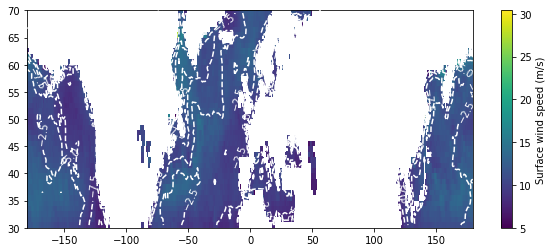

In [15]:
fig = plt.figure(figsize=(10,4))
scatter = plt.pcolormesh(mer_lon, mer_lat,np.mean(wind, axis=0),vmin=np.min(wind),vmax=np.max(wind))
f = plt.contour(mer_lon, mer_lat,np.mean(plot_CAOI, axis=0),colors='white')
cbar = plt.colorbar(scatter)
plt.clabel(f, inline=True, fontsize=10)
cbar.ax.set_ylabel('Surface wind speed (m/s)')

In [36]:
ind = np.argsort(plot_mer_theta)
xx = np.sort(plot_mer_theta)
yy = plot_mac_wind[ind]

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')

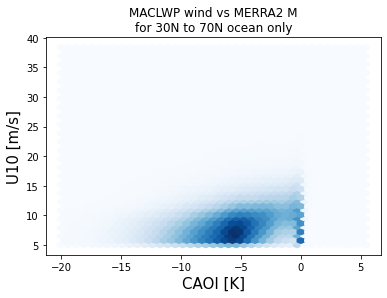

In [12]:
hb = plt.hexbin(xx, yy, gridsize=40, cmap='Blues')
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')

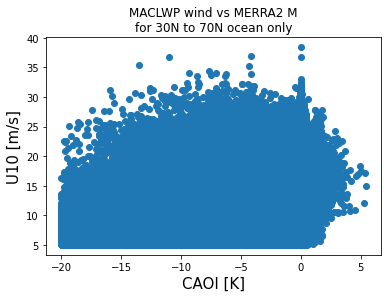

In [13]:
plt.scatter(xx, yy)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')

In [37]:
indx = np.isnan(xx*yy)==False

In [38]:
bin_means, bin_edges, binnumber = stats.binned_statistic(xx[indx], yy[indx], 'mean', bins=100)
bin_means_x, bin_edges_x, binnumber_x = stats.binned_statistic(xx[indx], xx[indx], 'mean', bins=100)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

mac_bin_means = bin_means[~np.isnan(bin_means)]
mac_bin_centers = bin_centers[~np.isnan(bin_means)]

# plt.scatter(mac_bin_centers, mac_bin_means)
# plt.ylabel('U10 [m/s]',fontsize='15')
# plt.xlabel('CAOI [K]',fontsize='15')
# plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')
# plt.savefig('try.png')

In [16]:
np.shape(xx)

(15782400,)

In [17]:
np.shape(yy)

(15782400,)

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

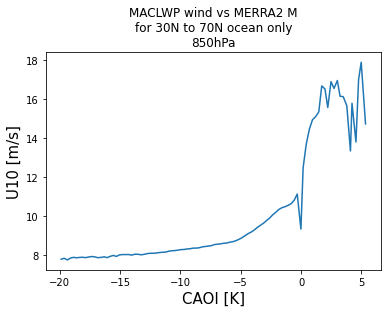

In [18]:
plt.plot(bin_means_x, bin_means)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n800hPa')

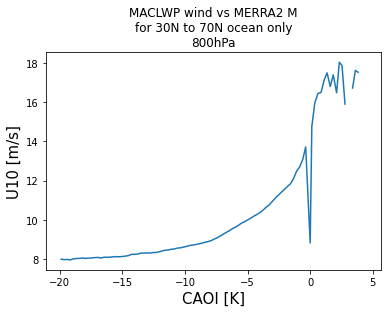

In [30]:
plt.plot(bin_means_x, bin_means)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n800hPa')

In [39]:
l = loess(bin_means_x,bin_means) #, surface='direct'
l.fit()
pred = l.predict(bin_means_x, stderror=True)
conf = pred.confidence()

macloess = pred.values
ll = conf.lower
ul = conf.upper
finaltheta = bin_means_x

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

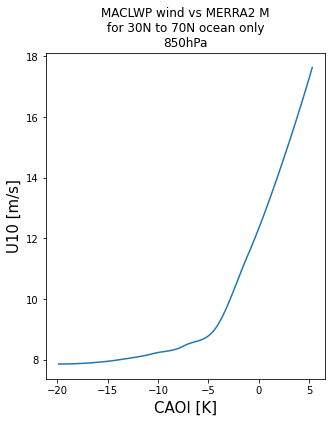

In [40]:
fig= plt.figure(figsize=(5, 6))
plt.plot(finaltheta, macloess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

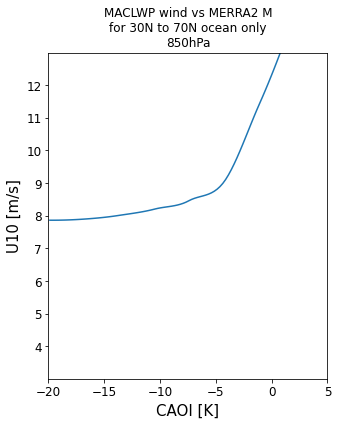

In [20]:
fig= plt.figure(figsize=(5, 6))
plt.plot(finaltheta, macloess)
plt.xticks(np.arange(-20,6,5),fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n850hPa')

Text(0.5, 1.0, 'MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')

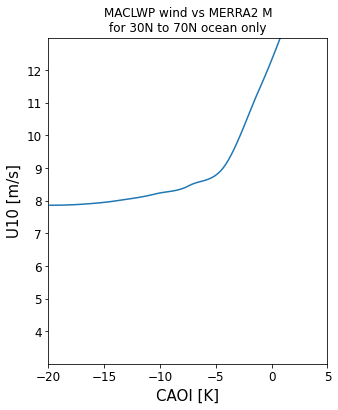

In [86]:
fig= plt.figure(figsize=(5, 6))
plt.plot(finaltheta, macloess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.xticks(np.arange(-20,6,5),fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n800hPa')

In [ ]:
l = loess(xx,yy) #, surface='direct'
l.fit()
pred = l.predict(xx, stderror=True)
conf = pred.confidence()

macloess = pred.values
ll = conf.lower
ul = conf.upper
finaltheta = xx

In [ ]:
fig= plt.figure(figsize=(5, 6))
plt.plot(finaltheta, macloess)
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.xticks(np.arange(-20,6,5),fontsize='12')
plt.yticks(np.arange(4,13),fontsize='12')
plt.xlim([-20,5])
plt.ylim([3,13])
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only\n800hPa with raw values loess')
plt.ylabel('U10 [m/s]',fontsize='15')
plt.xlabel('CAOI [K]',fontsize='15')
plt.title('MACLWP wind vs MERRA2 M\nfor 30N to 70N ocean only')